In [75]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

### Load the image
let us start by loading the image that we wish to process

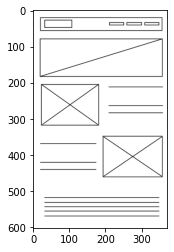

In [52]:
# read input image
img = cv2.imread('test.png')

# display it
plt.imshow(img)

### Masking Image 
now we mask the image to simplify the data that we have stored in the numpy array. Once we have masked the image, the image becomes black and white, with only two possible values that exist in the numpy array. One is 0 which means that the pixel contains no data (and is white sapce) and the other option is 255 (which appears as black)

In [53]:
# define border color
lower = (0, 80, 110)
upper = (0, 120, 150)

# threshold on border color
mask = cv2.inRange(img, lower, upper)

# dilate threshold
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel)

# recolor border to white
# img[mask==255] = (255,255,255)

In [54]:
# convert img to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# otsu threshold
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU )[1] 

# apply morphology open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))
morph = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
morph = 255 - morph

### Filtered, Masked Image

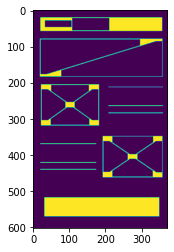

In [55]:
plt.imshow(morph)

In [33]:
#  check if given line has a component or not, return true when the given line is part of some component
def hasComponent(line):
    flag = False
    
    for pixelValue in line:
        if pixelValue != 0:
            return True
    
    return False

In [63]:
def find_lines_which_contain_component():
    lines_with_components = []

    for i in range(0, len(morph)):
        if(hasComponent(morph[i])):
            lines_with_components.append(i)
            
    return lines_with_components
    
lines_with_components = find_lines_which_contain_component()

print(f"Total Lines that make the entire image : {len(thresh)}")
print(f"Lines which make up the components on given image : {len(lines_with_components)}")

Total Lines that make the entire image : 602
Lines which make up the components on given image : 424


### Image after removing extra area
Now we have processed the image and found all the lines that form the components, in the next image, we display the image that we get after removing the spaces

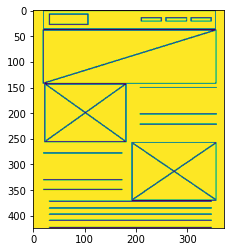

In [64]:
# display the items that are part of the list
def show_image_by_line(lines_to_show):
    display_lines = []
    for i in range(0, len(thresh)):
        if i in lines_to_show:
            display_lines.append(thresh[i])
    plt.imshow(display_lines)
    
show_image_by_line(lines_with_components)

### Extracting the whitespace data
once we remove the lines that make up the components, we get only those lines which make up the white space. Once we get the lines that make up the whitespace, we can find their midpoints and then split the image on basis of that. 

If you see an empty image in the demo, it is **expected**! It means that we have captured all the empty lines. 

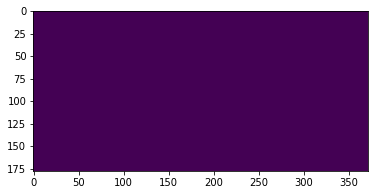

In [67]:
def find_empty_lines(image, lines_with_components):
    all_lines = range(0, len(image))
    empty_lines = []
    
    for some_line in all_lines:
        if some_line not in lines_with_components:
            empty_lines.append(some_line)
            
    return empty_lines
        

empty_lines = find_empty_lines(thresh, lines_with_components)
show_image_by_line(empty_lines)

# Finding breakpoints

`lines_with_components` contains index of all lines which have a component (see demo function above to visualize the data), now we find the ranges that are missing, and their mid point to find the breakpoints. 

In [25]:
def find_breakpoints(line_with_components):
    breakpoints = []
    
    i = 0
    start = i
    end = i
    counter = line_with_components[i]
    
    while i < len(line_with_components):
        if counter == line_with_components[i]:
            counter+=1
            i+=1
        else:
            end = counter
            breakpoints.append([start,end])
            
            counter = line_with_components[i] 
            start = counter
            
    
    return breakpoints        

In [68]:
breakpoint_ranges =  find_breakpoints(empty_lines)
breakpoint_ranges

[[0, 20], [58, 79], [184, 205], [319, 348], [462, 517]]

now since we have a range of areas that do not have any component, we find the midpoint of each of these ranges to find the exact index we need to split the image

In [69]:
def find_midpoints_of_ranges(breakpoint_ranges):
    midpoints = []
    
    for i in range(0, len(breakpoint_ranges)):
        midpoints.append((breakpoint_ranges[i][0] + breakpoint_ranges[i][1])//2)
    
    return midpoints

breakpoints = find_midpoints_of_ranges(breakpoint_ranges)
breakpoints

[10, 68, 194, 333, 489]

In [70]:
# first limit is the start of the images
final_break_points = [0]

# now get all the calculated breakpoints
for breakpoint in breakpoints:
    final_break_points.append(breakpoint)
    
# add final boundary of the image
final_break_points.append(len(thresh))
    
final_break_points

[0, 10, 68, 194, 333, 489, 602]

Now we pair up the array to get groups of two, which act as the lower and upper bound of the image

In [71]:
def get_pairs_from_breakpoints(breakpoints):
    pairs = []
    for i in range(0, len(breakpoints)-1):
        pairs.append([breakpoints[i], breakpoints[i+1]])
    return pairs

breakpoint_pairs = get_pairs_from_breakpoints(final_break_points)
breakpoint_pairs

[[0, 10], [10, 68], [68, 194], [194, 333], [333, 489], [489, 602]]

Now we have the data as to how to split the image, let us divide the passed image and return a list that can be directly visualzied

In [72]:
def extracted_segments(image, breakpoint_pairs):
    image_segments = []
    
    for i in breakpoint_pairs:
        image_segments.append( thresh[i[0]:i[1]] )
    
    return image_segments

extracted_image_segments = extracted_segments(thresh, breakpoint_pairs)
print(f"Total {len(extracted_image_segments)} components extracted from the image")

Total 6 components extracted from the image


Now once we have data to generate the image components, simply write these items to the disk

In [73]:
def save_images_to_disk(image_segments, name_prefix):
    counter = 1
    
    for data in image_segments:
        img = Image.fromarray(data)
        img.save(f"{name_prefix}_{counter}.jpeg")
        print(f"Segment #{counter} written to disk")    
        counter+=1
    

save_images_to_disk(extracted_image_segments, "demo")

Segment #1 written to disk
Segment #2 written to disk
Segment #3 written to disk
Segment #4 written to disk
Segment #5 written to disk
Segment #6 written to disk


In [32]:
!pwd

/home/yash/Desktop/files/works/projects/sketch2Site/site-generator
